## Auto-Tuner
I will use this notebook to auto-tune to required configuratios. The CNN classifier will be used to identify the state of the device. This state will be tuned using an optimzer to a required state.

I will do auto-tuning of two types. In both types, it will be focused on the single to double dot transition.
* plunger tuning : The state will be tuned in the two-dimensional space of plunger voltages. This will be done with simulated data.
* central barrier tuning: The state will be tuned in the one-dimensional space of the barrier. This will be be done with experimental data.

In [227]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import scipy.interpolate
import glob
import scipy.optimize

import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams.update({'font.size': 12})

import matplotlib.cm as cm
mpl.rcParams['font.family'] = "serif"

## Loading the trained CNN
I will load the trained CNN into substate_classifier variable.

In [177]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features["x"],[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out2 = tf.layers.dense(inputs=dropout1,units=256,activation=tf.nn.relu)  
    dropout2 = tf.layers.dropout(
      inputs=out2, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout2, units=4)
    
    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1)
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=tf.argmax(labels,axis=1), predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

model_dir = "/Users/sandesh/trained_networks/substate_classifier/"
substate_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=model_dir)

## 1: Plunger space tuning
I will load data for a full sub-region. One 100x100 map will be used.

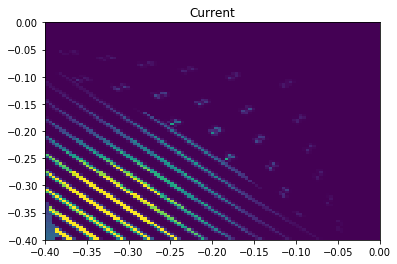

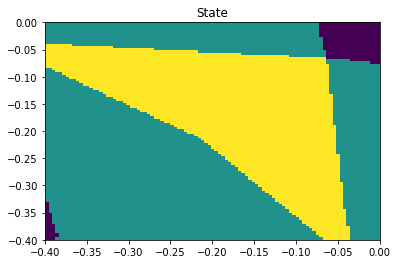

In [178]:
# just load one of the full maps 
files = glob.glob("/Users/sandesh/data/quantum-ml/data_for_paper/double_dot_low_var/*.npy")
index = np.random.randint(len(files))
index = 100
sample_data = np.load(files[index]).item()

V_P1_vec = sample_data['V_P1_vec']
V_P2_vec = sample_data['V_P2_vec']
N_v = len(V_P1_vec)
current = np.array([x['current'] for x in sample_data['output']]).reshape(N_v,N_v)
state = np.array([x['state'] for x in sample_data['output']]).reshape(N_v,N_v)

XX,YY = np.meshgrid(V_P1_vec,V_P2_vec)
plt.figure(1)
plt.pcolor(XX,YY,current,vmax=1e-4)
plt.title("Current")
plt.figure(2)
plt.pcolor(XX,YY,state)
plt.title("State")

### Fitness function
I will define a fitness function which will be the distance between a required prob. vector of a subregion and the prob. vector produced from the CNN.

In [206]:
def fitness(subimage,prob_0,substate_classifer=substate_classifier):
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e4*subimage},
      y=None,
      num_epochs=1,
      shuffle=False)

    prob = [x['prob'] for x in list(substate_classifier.predict(input_fn = test_input_fn))]
    fitness = np.array([np.linalg.norm(x-prob_0) for x in prob])
    return fitness

In [209]:
def take_subimage(x,y,image,subsize = 30):
    return image[(x-subsize//2):(x+subsize//2),(y-subsize//2):(y+subsize//2)]

Fitness (lower is better) [ 0.04665258]


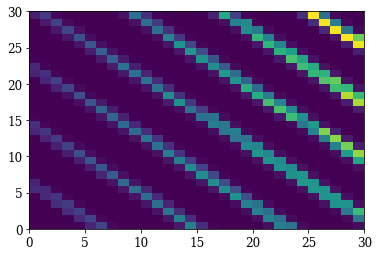

In [210]:
x,y = np.random.randint(15,84,2)
subimage = take_subimage(x,y,current)
plt.pcolor(subimage)

prob_0 = np.array([0,0,1,0])
print("Fitness (lower is better)",fitness(subimage,prob_0))


### Evaluation of fitness function
I will evaluate the fitness function over the full image to see how the landscape looks like.

In [207]:
prob_0 = np.array([0,0,1,0])
subimage_array = np.array([take_subimage(x,y,current) for x in range(15,84) for y in range(15,84)])
fitness_array = np.array(fitness(subimage_array,prob_0))

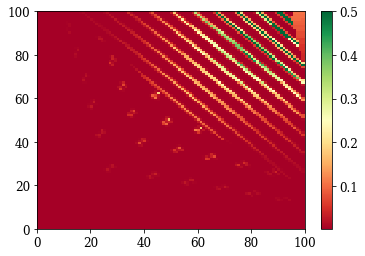

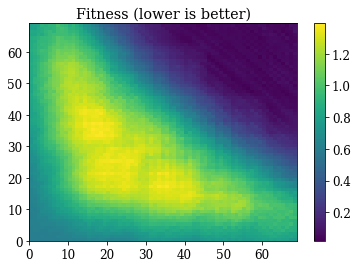

In [216]:
plt.figure(1)
plt.pcolor(1e4*current/np.max(1e4*current),cmap=cm.RdYlGn,vmax=5e-1,vmin=1e-3)
plt.colorbar()
plt.figure(2)
plt.pcolor(fitness_array.reshape(-1,int(np.sqrt(fitness_array.shape[0]))))
plt.title("Fitness (lower is better)")
plt.colorbar()

## Define the optimizer function and auto-tune

32 45
Initial fitness [ 1.28749957]
32 45
42 45
42 55
44 64
54 68
63 71
64 81
73 68
60 67
66 70
63 73
62 70
64 71
63 71
63 71
63 71
63 71
63 71
63 71
63 71
63 71
63 71
63 71
63 71
     fun: 0.020793945401313494
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([ 63.79021531,  71.09979984])


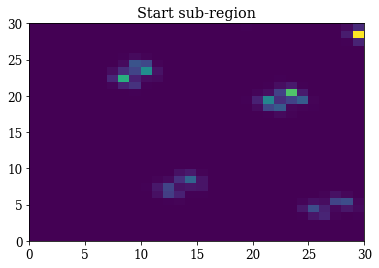

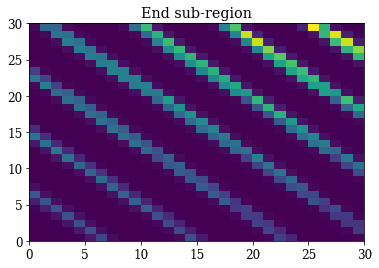

In [225]:
x_0 = 32
y_0 = 45
prob_0 = np.array([0,0,1,0])
start_subimage = take_subimage(x_0,y_0,current)

# define a fitness function of pos = (x,y)
def fitness_pos(pos,current,substate_classifer=substate_classifier,prob_0=prob_0):
    x = int(pos[0])
    y = int(pos[1])
    print(x,y)
    subimage = take_subimage(x,y,current)
    return fitness(subimage,prob_0,substate_classifier)

print("Initial fitness",fitness_pos((x_0,y_0),current))

guess = np.array([x_0,y_0])
cons = [{"type":"ineq","fun":lambda x: x[0] - 18},
        {"type":"ineq","fun":lambda x: x[1] - 18},
        {"type":"ineq","fun":lambda x: 83 - x[0]},
        {"type":"ineq","fun":lambda x: 83 - x[1]}]

res = scipy.optimize.minimize(fitness_pos,x0=guess,args=(current,substate_classifier,prob_0),method="cobyla",
                              options={"rhobeg":10.0,"disp":3},constraints=cons)
print(res)

x = int(res.x[0])
y = int(res.x[1])
final_sub_image = take_subimage(x,y,current) 

plt.figure(1)
plt.pcolor(start_subimage)
plt.title("Start sub-region")
plt.figure(2)
plt.title("End sub-region")
plt.pcolor(final_sub_image)


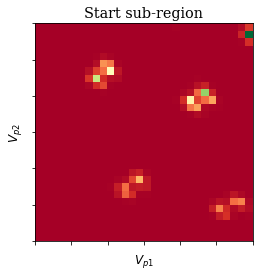

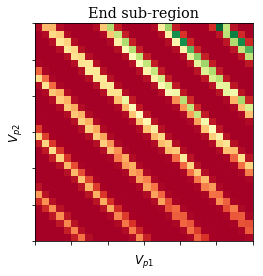

In [235]:
plt.figure(1)
plt.pcolor(start_subimage,cmap=cm.RdYlGn)
plt.title("Start sub-region")
plt.xlabel(r"$V_{p1}$")
plt.ylabel(r"$V_{p2}$")
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.set_aspect('equal')
plt.savefig("/Users/sandesh/Desktop/start_sub.png",dpi=300)
plt.figure(2)
plt.title("End sub-region")
plt.pcolor(final_sub_image,cmap=cm.RdYlGn)
plt.xlabel(r"$V_{p1}$")
plt.ylabel(r"$V_{p2}$")
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.set_aspect('equal')
plt.savefig("/Users/sandesh/Desktop/end_sub.png",dpi=300)


## Auto-tuning of experimental data 
Here, there is only one variable than I can vary in the dataset which the central barrier gate voltage.

#### Loading of experimental data into a single array.

In [173]:
x_test_data = []
# 100x100 images for better viewing
x_test_data_100 = []
for index in range(1,10):
    filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
    dat = np.loadtxt(filename)

    # values from the data
    points = (dat[:,0],dat[:,2])
    values = dat[:,3]

    V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),30)
    V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),30)
    XX,YY = np.meshgrid(V_b1,V_b2)

    z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest") 
    x_test_data.append(z)
    
    V_b1_100 = np.linspace(np.min(points[0]),np.max(points[0]),100)
    V_b2_100 = np.linspace(np.min(points[1]),np.max(points[1]),100)
    XX_100,YY_100 = np.meshgrid(V_b1_100,V_b2_100)

    z1 = scipy.interpolate.griddata(points,values,(XX_100,YY_100),method="nearest") 
    x_test_data_100.append(z1)
    
x_test_data = np.array(x_test_data)
x_test_data_100 = np.array(x_test_data_100)

I will use a slightly different fitness function because the scale of the current in the experimental data is 
different in the experimental data.

In [169]:
def exp_fitness(subimage,prob_0,substate_classifer=substate_classifier):
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1.0e2*subimage},
      y=None,
      num_epochs=1,
      shuffle=False)

    prob = [x['prob'] for x in list(substate_classifier.predict(input_fn = test_input_fn))]
    fitness = np.array([np.linalg.norm(x-prob_0) for x in prob])
    return fitness

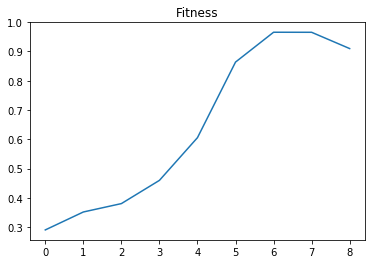

In [170]:
prob_0 = np.array([0,0,1,0])
fitness_vec = exp_fitness(x_test_data,prob_0)
plt.title("Fitness")
plt.plot(fitness_vec)

2
Initial fitness [ 4.20799148]
2
4
6
8
8
8
8
8
8
     fun: 0.71208116272785282
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 9
  status: 1
 success: True
       x: array(8.0)


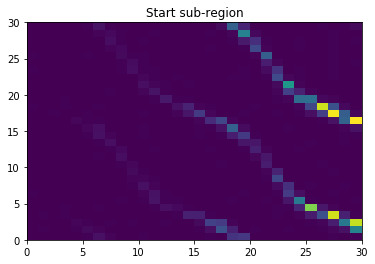

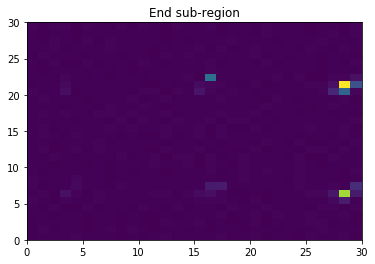

In [171]:
x_0 = 2
prob_0 = np.array([0,0,0,1])
start_subimage = x_test_data[x_0]

# define a fitness function of pos = (x,y)
def fitness_pos(pos,current,substate_classifer=substate_classifier,prob_0=prob_0):
    x = int(pos)
    print(x)
    subimage = x_test_data[x]
    return fitness(subimage,prob_0,substate_classifier)

print("Initial fitness",fitness_pos(x_0,current))

guess = x_0
cons = [{"type":"ineq","fun":lambda x: x},
        {"type":"ineq","fun":lambda x: 8 - x}]

res = scipy.optimize.minimize(fitness_pos,x0=guess,args=(current,substate_classifier,prob_0),method="cobyla",
                              options={"rhobeg":2.0,"disp":3},constraints=cons)
print(res)

x = int(res.x)
final_sub_image = x_test_data[x] 

plt.figure(1)
plt.pcolor(start_subimage)
plt.title("Start sub-region")
plt.figure(2)
plt.title("End sub-region")
plt.pcolor(final_sub_image)


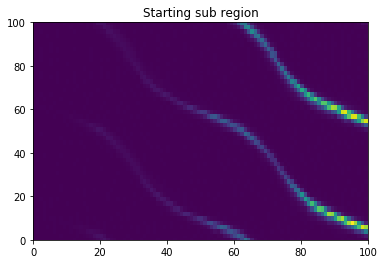

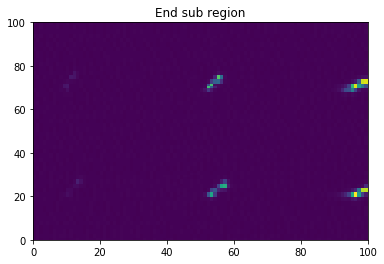

In [175]:
plt.figure(1)
plt.pcolor(x_test_data_100[2])
plt.title("Starting sub region")
plt.figure(2)
plt.pcolor(x_test_data_100[8])
plt.title("End sub region")

In [201]:
98*98

9604